In [1]:
import re
import os
import sys
import pickle
import time
import random
import warnings
from datetime import datetime
import logging
from functools import reduce
from multiprocessing import Process

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata, gmean,pearsonr
from scipy.sparse import csr_matrix
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE,RFECV,VarianceThreshold,SelectKBest,chi2, SelectFromModel, f_classif, mutual_info_classif
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler

In [2]:
def list_files(path, pattern, recursive = True, full_name = True):
    output = []
    def list_files_core(current_path = path, current_pattern = pattern, current_recursive = recursive, current_full_name = full_name):
        nonlocal output
        files = os.listdir(current_path)
        for file in files:
            file_path = os.path.join(current_path, file)
            
            if os.path.isdir(file_path) and current_recursive:
                list_files_core(file_path, current_pattern, current_recursive, current_full_name)
            
            else:
                if re.search(current_pattern, file):
                    if full_name == True:
                        file = os.path.join(current_path, file)
                        output.append(file)
                    else:
                        output.append(file)
    list_files_core()
    return output
            

In [3]:
def convert_data(data = None, path = None, assay = ".X",label_column = None):
    """
    A function to convert sparse matrix into pandas data frame object. 
    
    Parameters:
    data: a Annot Data object. If speciefied, path should be specified in 'None'.
    path: path to h5ad file. If speciefied, data should be specified in 'None'.
    assay: ".X" or "raw" assay in Annot Data object could be specified
    label_column: the name of cell type column in the h5ad file. 
    If specified, the cell type column will be added into output.
    """
    if path != None:
        data = sc.read(path)
    
    if assay == ".X":
        counts = pd.DataFrame.sparse.from_spmatrix(data.X)
    else:
        counts = pd.DataFrame.sparse.from_spmatrix(data.raw.X)
        
    features = data.raw.var_names.tolist()
    index  = data.raw.obs_names.tolist()
    
    counts.columns = features
    counts.index = index
    
    if label_column != None:
        try:
            labels = data.obs[label_column].tolist()
            counts["cell_type"] = labels
        except:
            raise ValueError("The length of cell type column is not consistent with matrix")

    return counts

In [4]:
def quantile_normalize(data):
    """
    A function to do quantile normalization.  
    
    """
    data = data.loc[:, data.columns != "cell_type"]
    ranks = (data.rank(method = "first").stack())
    rank_mean = (data.stack().groupby(ranks).mean())
    # add interproblated values in between ranks
    finer_ranks = ((rank_mean.index + 0.5).tolist() + rank_mean.index.tolist())
    rank_mean = rank_mean.reindex(finer_ranks).sort_index().interpolate()
    data = data.rank(method = "average").stack().map(rank_mean).unstack()
    
    return data
    

In [5]:
def record_time():
    """
    A function to call out current time.
    """
    current_second_time = datetime.now()
    return current_second_time.strftime("%Y-%m-%d %H:%M:%S")

In [6]:
class log_file:
    """
    A class to easily write log information into different log files.
    
    filename: log file name 
    mode: "a" (append log information) or "w" (clean up old log information and then write new information)
    """
    n_class = 0
    def __init__(self, filename, mode):
        self.time = record_time()
        self.filename = filename
        self.mode = mode
        self.logger = None
        self.n_object = 0
        log_file.n_class += 1
        
    def set(self):
        logger = logging.getLogger("my_logger")
        logger.setLevel(logging.INFO)
        log_file_name = "{}_{}.log".format(self.filename, self.time)
        file_handler = logging.FileHandler(log_file_name, mode = self.mode)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
        self.logger = logger
        
    def start(self):
        if log_file.n_class == 1 and self.n_object == 0:
            self.set()
        if log_file.n_class > 1 and self.n_object == 0:
            self.set()
        
    def write(self, category, content):
        self.start()
        self.n_object += 1
        if category == "info":
            self.logger.info(content)
        elif category == "error":
            self.logger.error(content)
        elif category == "warning":
            self.logger.warning(content)
        elif category == "debug":
            self.logger.debug(content)
        elif category == "critical":
            self.logger.critical(content)
    
    def mode_reset(self, mode):
        self.mode = mode
        
    def clear():
        log_file.n_class = 0

In [7]:
def remove_time(string, count = 1):
    """
    A function to remove time information in the stdout message"
    """
    pattern = re.compile("\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}")
    res = re.sub(pattern, "", string, count = count)
    return res.rstrip().lstrip()

In [8]:
def pre_processing(path, 
                   label_column,
                   assay = ".X", 
                   convert = True,
                   log_normalize = True, 
                   scale_data = False, 
                   fiter_samples = False,
                   quantile_normalize = False,
                   save = False,
                   logger = None):
    """
    A function to do preliminary normalization, encoding label and convert data into pandas data frame for downstream sklearn-based
    machine learning workflow.
    
    Parameters:
    path: path to the h5ad file.
    assay: ".X" or "raw" assay in Annot Data object could be specified.Default is ".X".
    label_column: The name of cell type column in the h5ad file.If specified, the cell type column will be added into output.
    convert: Bool value to decide whether convert Annot Data object into pandas data frame object.
    log_normalize: Bool value to decide whether standard log normalization to be done.
    scale_data: Bool value to decide whether standadlize data or not.
    quantile_normalize: Bool value to decide whether quantile normalize data or not.
    save: Bool value to decide whether write the pre-processed data into the disk.
    logger: A log_file object to write log information into disk. Default is None. 
    """
    if logger != None:
        logger.write("info", "start pre processing")
        logger.write("critical", "Parameters used for pre_processing")
        parameters = {"path": path,
                      "label_column": label_column,
                      "assay": assay,
                      "convert": convert,
                      "log_normalize": log_normalize,
                      "scale_data": scale_data,
                      "quantile_normalize": quantile_normalize,
                      "save": save
                     }
        for key,value in parameters.items():
            logger.write("critical", "{}: {}".format(key, value))
    
    data = sc.read(path)
    
    if log_normalize:
        sc.pp.normalize_total(data, target_sum = 1e4)
        sc.pp.log1p(data)
    
    if scale_data:
        sc.pp.scale(data)
        
#     if filter_samples:
#         sc.pp.calculate_qc_metrics(data, inplace = True)
        
    if convert:
        counts = convert_data(data = data, assay = assay, label_column = label_column)
    else:
        counts = data.X
        
    if quantile_normalize:
        quant_norm_data = convert_data(data, assay = assay)
        counts = quantile_normalize(data.X)
    
    # convert string label into numeric label
    labels = data.obs[label_column].unique().tolist()
    labels.sort()
    label = data.obs[label_column].apply(lambda x: labels.index(x))
    
    res = {"matrix": counts, 
           "convert_label": label, 
           "original_label": data.obs[label_column], 
           "sort_uniq_label": labels} 
    
    if save:
        file_name = "Preprocessing_data_{}.pkl".format(record_time())
        with open(file_name, "wb") as output:
            pickle.dump(res, output)
    
    if logger != None: 
        logger.write("info", "finish pre processing")
    
    return res

In [9]:
def reverse_rank_weight(x):
    """
    A function to reverse rank weight to makre sure the greatest ranking value representing the most importance.
    """
    assert isinstance(x, dict), "x should be dictionary"
    unique_values = list(set(x.values()))
    unique_values.sort()
    half_length = int(len(unique_values) / 2)
    
    d = dict()
    
    for key, value in x.items():
        if value > unique_values[half_length]:
            for i in range(-1, -half_length-1, -1):
                if unique_values[i] == value:
                    j = i + (i * -2) - 1
                    d[key] = unique_values[j]
        
        else:
            for i in range(half_length+1):
                if unique_values[i] == value:
                    j = i + 1
                    d[key] = unique_values[-j]
    return d    

In [10]:
def check_duplicated_elements(x):
    """
    A function to fix duplicated string elements in the list by adding ordinal suffix.
    """
    
    assert isinstance(x, list), "x should be list."
    assert all(map(lambda x: isinstance(x, str), x)), "elements in the list should be string."
    
    if len(x) != len(set(x)):
        warnings.warn("Duplicated elements exist. To fix this, duplicated elements will be added suffix such as _1, _2..._n")
        duplicate = []
        unique = []
        index = []
        
        for i in x:
            if i not in unique:
                unique.append(i)
            else:
                duplicate.append(i)
        
        d = dict()
        for i in set(duplicate):
            for j in range(len(x)):
                if x[j] == i:
                    index.append(j)
            d[i] = index
            index = []
            
        for key, value in d.items():
            for i in range(len(value)):
                replacement = key + "_" + str(i+1)
                x[value[i]] = replacement
        
    return x

In [11]:
def feature_selection(data, 
                      label_column,
                      filename,
                      logger = None,
                      rank_method = "dense",
                      merge_rank_method = "geom.mean",
                      variance_threshold = "zero",
                      mutual_info = True, 
                      chi_square_test = False,
                      F_test = False,
                      model = "random_foreast",
                      random_foreast_threshold = None,
                      n_estimators = 100,
                      random_state = 10,
                      logistic_multi_class = "ovr",
                      kernel = "linear",
                      normalization_method = "Min-Max",
                      linear_svm_multi_class = "ovr",
                      n_features_to_select = 3000,
                      step = 100,
                      cv = 5,
                      n_jobs = -1,
                      save = True):
    """
    A function to do feature seletion based on filtering, embedding and wrapping method respectively or combing those methods together.
    
    Parameters:
    data: A pandas data frame object.
    label_column: The name of cell type column in the data.
    logger: A log_file object to write log information into disk. Default is None. 
    random_foreast_threshold. A float or int value to set the cutoff (feature_importance_) by random foreast model-basedd embedding feature selection.It needs to be specified when model is set in 'random_foreast'. Default is `1 / the number of all features`
    variance_threshold: A string to decide which variance cutoff is used to filter out features."zero" or "median" could be selected. 
    mutual_info: Bool value decide whether a mutual information method is employed to filtering out features further.
    chi_sqaure_test: A Bool value decide whether a chi square test method is employed to filtering out features further.
    F_test: Bool value decide whether a F test method is employed to filtering out features further.
    model: String to decide which model is used by embedding-based feature selection. "random_foreast", "logistic" and "svm" could be selected.
    n_estimators: The number of trees in the forest.
    random_state: Controls both the randomness of the bootstrapping of the samples used when building trees (if ``bootstrap=True``) and the sampling of thefeatures to consider when looking for the best split at each node.
    kernel: Specifies the kernel type to be used in the support vector machine algorithm.
    decision_function_shape: Whether to return a one-vs-rest ('ovr') decision function of shape (n_samples, n_classes) as all other classifiers, or the originalone-vs-one ('ovo') decision function of libsvm which has shape.(n_samples, n_classes * (n_classes - 1) / 2)
    n_featurs_to_selct: int or float, default=None.The number of features to select. If `None`, half of the features are selected. If integer, the parameter is the absolute number of features to select. If float between 0 and 1, it is the fraction of features to select.
    step:int or float, default=1. If greater than or equal to 1, then ``step`` corresponds to the (integer) number of features to remove at each iteration. If within (0.0, 1.0), then ``step`` corresponds to the percentage (rounded down) of features to remove at each iteration.
    save: Bool value to decide whether write the pre-processed data into the disk.
    """
    message = "{} {}".format(record_time(), "start feature selection")
    print(message)
    
    params = {
                "label_column": label_column,
                 "file_name": filename,
                 "rank_method": rank_method,
                 "random_foreast_threshold": random_foreast_threshold,
                 "variance_threshold": variance_threshold,
                 "mutual_info": mutual_info,
                 "chi_square_test": chi_square_test,
                  "F_test": F_test,
                  "model" : model,
                  "n_estimators": n_estimators,
                  "random_state": random_state,
                  "logistic_multi_class": logistic_multi_class,
                  "kernel": kernel,
                  "linear_svm_multi_class": linear_svm_multi_class,
                  "n_features_to_select": n_features_to_select,
                  "step" : step,
                  "save" : save
            }
    
    if logger != None:
        logger.write("info", remove_time(message))

        for key, value in params.items():
            logger.write("critical", "{}: {}".format(key, value))
    
    # step 1 - convert category label into numeric label
    message = "{} step 1 - converting categoric label into numeric label".format(record_time())
    print(message)
    if logger != None:
        logger.write("info", remove_time(message))
    
    # if label is string, converse to numeric label
    if any(map(lambda x: isinstance(x, str), data[label_column])):
        le = LabelEncoder().fit(data[label_column])
        label = le.transform(data[label_column])
        data[label_column] = label
    
    # fix duplicated column names by adding ordinal suffix
    data.columns = check_duplicated_elements(data.columns.tolist())
    
    # get data and label
    X = data.iloc[:, 0:-1]
    y = data.iloc[:, -1]
    
    # get all feature names
    all_features = list(data.iloc[:, 0:-1].columns)

    
    # step 2 - do feature selection
    message = "{} step 2 - do feature selection".format(record_time())
    print(message)
    if logger != None:
        logger.write("info", remove_time(message))
    
    message = "{} ======== filtering based selection ========".format(record_time())
    print(message)
    if logger != None:
        logger.write("info", remove_time(message))
    
        
    # filtering-based feature selection
    # filter out by variance 
    if variance_threshold == "zero":
        var_selector = VarianceThreshold()
        X_var = var_selector.fit_transform(X)
        
        # features selection by ensemble mode
        retained_features_ranking_by_variance = dict([*zip(var_selector.feature_names_in_, rankdata(var_selector.variances_, method = rank_method))])
        message = "* {} {}".format(record_time(), "feature ranking based on variance of each feature")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
        
        # features selection by intersection mode
        retained_features_by_filter = X.columns[var_selector.get_support()]
        message = "* {} {} features remained after filter out features with 0 variance".format(record_time(), X_var.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
        

    elif variance_threshold == "median":
        var_selector = VarianceThreshold(np.median(np.var(np.array(X), axis = 0)))
        X_var = var_selector.fit_transform(X)
        
        # features selection by ensemble mode
        retained_features_ranking_by_variance = dict([*zip(var_selector.feature_names_in_, rankdata(var_selector.variances_, method = rank_method))])
        message = "* {} {}".format(record_time(), "feature ranking based on variance of each feature")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
                
        # features selection by intersection mode
        retained_features_ranking_by_variance_filter = X.columns[var_selector.get_support()]
        message = "* {} {} features remained after filter out features below median variance of all features".format(record_time(), X_var.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    # filter by chi sqaure test
    if chi_square_test and F_test == False:
        
        # features selection by ensemble mode
        chivalue, pvalues_chi = chi2(X, y)
        # when pvalue is NaN, it will be replaced with 1
        pvalues_chi = [1 if np.isnan( _ ) else _ for _ in pvalues_chi]
        retained_features_ranking_by_correlation = dict([*zip(all_features, rankdata(pvalues_chi, method = rank_method))])
        # reverse the ranking weight to make sure the greatest weight representing the most importance
        retained_features_ranking_by_correlation = reverse_rank_weight(retained_features_ranking_by_correlation)
        message = "* {} {}".format(record_time(), "feature ranking based on p value calculated by chi square test to check the correlation between feature and lable")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
        
        # features selection by intersection mode
        chivalue, pvalues_chi = chi2(X_var, y)
        k = chivalue.shape[0] - (pvalues_chi > 0.05).sum()
        selector = SelectKBest(chi2, k = k)
        X_fschi = selector.fit_transform(X_var, y)
        retained_features_by_filter = retained_features_by_filter[selector.get_support()]
        message = "** {} {} features remained after further chi sqaure test filtering".format(record_time(), X_fschi.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    # filter by F test
    if F_test and chi_square_test == False:
        
        # features selection by ensemble mode
        F, pvalues_f = f_classif(np.array(X), y)
        # when pvalue is NaN, it will be replaced with 1
        pvalues_f = [1 if np.isnan( _ ) else _ for _ in pvalues_f]
        retained_features_ranking_by_correlation = dict([*zip(all_features, rankdata(pvalues_f, method =  rank_method))])
        # reverse the ranking weight to make sure the greatest weight representing the most importance
        retained_features_ranking_by_correlation = reverse_rank_weight(retained_features_ranking_by_correlation)
        message = "* {} {}".format(record_time(), "feature ranking based on p value calculated by F test to check the correlation between feature and lable")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
        
        # features selection by intersection mode
        F, pvalues_f = f_classif(X_var, y)
        k = F.shape[0] - (pvalues_f > 0.05).sum()
        selector = SelectKBest(f_classif, k = k)
        X_fsF = selector.fit_transform(X_var, y)
        retained_features_by_filter = retained_features_by_filter[selector.get_support()]
        message = "** {} {} features remained after further F test filtering".format(record_time(), X_fsF.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    # filter by mutual infomation
    if (F_test == False and chi_square_test == False) and mutual_info:
        
        # features selection by ensemble mode
        res = mutual_info_classif(X, y)
        retained_features_ranking_by_correlation = dict([*zip(all_features, rankdata(res, method = rank_method))])
        message = "* {} {}".format(record_time(), "feature ranking based on p value calculated by mutual information to check the correlation between feature and lable")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
        
        # features selection by intersection mode
        res = mutual_info_classif(X_var, y)
        k = res.shape[0] - sum(res <= 0)
        selector = SelectKBest(mutual_info_classif, k = k)
        X_fsmic = selector.fit_transform(X_var, y)
        retained_features_by_filter = retained_features_by_filter[selector.get_support()]
        message = "** {} {} features remained after further mutual information filtering".format(record_time(), X_fsmic.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    message = "{} ======== embedding based selection ========".format(record_time())
    print(message)
    if logger != None:
        logger.write("info", remove_time(message))

    # embedding-based on feature selection
    # select by random foreast model
    if model == "random_foreast":
        RFC_ = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
        # when random_foreast_threshold is None, 
        #  `1 / number of features` will be used as threshold
        if random_foreast_threshold == None:
            random_foreast_threshold = 1 / X.shape[1] 
        RFC_embedding_selector = SelectFromModel(RFC_, threshold = random_foreast_threshold)
        X_RFC_embedding = RFC_embedding_selector.fit_transform(X, y)
        
        # features selection by ensemble mode
        retained_features_ranking_by_embedding = dict([*zip(RFC_embedding_selector.feature_names_in_ , rankdata(RFC_embedding_selector.estimator_.feature_importances_, method = rank_method))])
        message = "* {} {}".format(record_time(), "feature ranking based on feature importance calcualted by random foreast model")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
        
        # features selection by intersection mode
        retained_features_by_embedding = RFC_embedding_selector.get_feature_names_out()
        message = "* {} {} features remained after random foreast based embedding filtering".format(record_time(), X_RFC_embedding.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    # select by logistic regression model
    elif model == "logistic":
        if normalization_method == "Min-Max":
            X_stand = MinMaxScaler().fit_transform(np.array(X))
        elif normalization_method == "Standardization":
            X_stand = StandardScaler().fit_transform(np.array(X))
        
        logistic_ = LogisticRegression(multi_class = logistic_multi_class, random_state = random_state, max_iter=200)
        log_embedding_selector = SelectFromModel(logistic_, norm_order = 1)
        X_log_embedding = log_embedding_selector.fit_transform(X_stand, y)
        
        # features selection by ensemble mode
        retained_features_ranking_by_embedding = dict([*zip(log_embedding_selector.feature_names_in_, rankdata(np.sum(np.abs(log_embedding_selector.estimator_.coef_), axis = 0), method = rank_method))]) # sum all coefficients of each feature
        message = "* {} {}".format(record_time(), "feature ranking based on coefficient calcualted by logistic model")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
        
        # features selection by intersection mode
        retained_features_by_embedding = log_embedding_selector.get_feature_names_out()
        message = "* {} {} features remained after logistic regression based embedding filtering".format(record_time(), X_log_embedding.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    # select by SVM model
    elif model  == "svm":
        # Standardization or Min-Max scalingh is required for linear SVM 
        if normalization_method == "Min-Max":
            X_stand = MinMaxScaler().fit_transform(np.array(X))
        elif normalization_method == "Standardization":
            X_stand = StandardScaler().fit_transform(np.array(X))
        
        SVC_ = LinearSVC(multi_class =  linear_svm_multi_class)
        SVC_ = SVC_.fit(X_stand, y)
        SVC_embedding_selector = SelectFromModel(SVC_, norm_order = 1, prefit=True)
        X_SVC_embedding = SVC_embedding_selector.transform(np.array(X_stand))

        # features selection by ensemble mode
        feature_importance = rankdata(np.sum(np.abs(SVC_.coef_), axis = 0), method = rank_method) # sum all coefficients of each feature
        retained_features_ranking_by_embedding = dict([*zip(X.columns, feature_importance)])
        message = "* {} {}".format(record_time(), "feature ranking based on coefficient calcualted by linear SVM model")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
        
        # features selection by intersection mode
        retained_features_by_embedding = X.columns[SVC_embedding_selector.get_support()]
        message = "* {} {} features remained after svm based embedding filtering".format(record_time(), X_SVC_embedding.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    # selected by wrapping method
    message = "{} ======== wrapping based selection ========".format(record_time())
    print(message)
    if logger != None:
        logger.write("info", remove_time(message))
    
    if n_features_to_select == None:
        # when features to select is None,
        # 50% of all features will be used as threshold
        n_features_to_select = int(X.shape[1] * 0.5)

    if model == "random_foreast":
        RFC_ = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
        RFC_wrapping_selector = RFECV(RFC_, min_features_to_select = n_features_to_select, step = step, cv = cv, n_jobs= n_jobs)
        X_RFC_wrapping = RFC_wrapping_selector.fit_transform(X, y)
        
        # features selection by ensemble mode
        retained_features_ranking_by_wrapping = dict([*zip(RFC_wrapping_selector.feature_names_in_ , RFC_wrapping_selector.ranking_)])
        retained_features_ranking_by_wrapping = reverse_rank_weight(retained_features_ranking_by_wrapping)

        message = "* {} {}".format(record_time(), "feature ranking based on ranking provided RFE - random foreast model")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

        
        # features selection by intersection mode
        retained_features_by_wrapping = X.columns[RFC_wrapping_selector.support_]

        message = "* {} {} features remained after RFE - random foreast based wrapping filtering".format(record_time(), X_RFC_wrapping.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    elif model == "logistic":
        logistic_ = LogisticRegression(multi_class = logistic_multi_class, random_state = random_state, max_iter=200)
        log_wrapping_selector = RFECV(logistic_, min_features_to_select = n_features_to_select, step = step, cv = cv, n_jobs = n_jobs)
        X_log_wrapping = log_wrapping_selector.fit_transform(X_stand, y)
        
        # features selection by ensemble mode
        retained_features_ranking_by_wrapping = dict([*zip(log_wrapping_selector.feature_names_in_, log_wrapping_selector.ranking_)])
        retained_features_ranking_by_wrapping = reverse_rank_weight(retained_features_ranking_by_wrapping)
        message = "* {} {}".format(record_time(), "feature ranking based on ranking provided RFE - logistic model")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
                
        # features selection by intersection mode
        retained_features_by_wrapping = X.columns[log_wrapping_selector.support_]
        message = "* {} {} features remained after RFE - logistic regression based wrapping filtering".format(record_time(), X_log_wrapping.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    elif model == "svm":
        SVC_ = LinearSVC(multi_class = linear_svm_multi_class,)
        SVC_wrapping_selector = RFECV(SVC_, min_features_to_select = n_features_to_select, step = step, cv = cv, n_jobs = n_jobs)
        X_SVC_wrapping = SVC_wrapping_selector.fit_transform(X_stand, y)
        
        # features selection by ensemble mode
        retained_features_ranking_by_wrapping = dict([*zip(X.columns, SVC_wrapping_selector.ranking_)])
        retained_features_ranking_by_wrapping = reverse_rank_weight(retained_features_ranking_by_wrapping)
        message = "* {} {}".format(record_time(), "feature ranking based on ranking provided RFE - SVM model")
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
                
       # features selection by intersection mode
        retained_features_by_wrapping = X.columns[SVC_wrapping_selector.support_]
        message = "* {} {} features remained after RFE - svm based wrapping filtering".format(record_time(), X_SVC_wrapping.shape[1])
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))

    message = "{} ======== final feature selection ========".format(record_time())
    print(message)
    if logger != None:
        logger.write("info", remove_time(message))
                
        
    #  features selection by ensemble mode
    rank_ls = list()

    for feature in all_features:
        ranks = [retained_features_ranking_by_variance[feature], retained_features_ranking_by_correlation[feature], retained_features_ranking_by_embedding[feature], retained_features_ranking_by_wrapping[feature]]
        if merge_rank_method == "max":
            rank_ls.append((feature, max(ranks)))
        elif merge_rank_method == "median":
            rank_ls.append((feature, np.median(np.array(ranks))))
        elif merge_rank_method == "mean":
            rank_ls.append((feature, np.mean(np.array(ranks))))
        elif merge_rank_method == "geom.mean":
            rank_ls.append((feature, gmean(np.array(ranks))))

    rank_ls = sorted(rank_ls, key = lambda x: -x[1])
    rank_ls = [ _ for _ in rank_ls[0:n_features_to_select] ]

    #  features selection by intersection mode
    retained_features_by_filter = set(retained_features_by_filter)
    retained_features_by_embedding = set(retained_features_by_embedding)
    retained_features_by_wrapping = set(retained_features_by_wrapping)

    final_feture_selection = reduce(lambda x,y: x.intersection(y), [retained_features_by_embedding, retained_features_by_filter, retained_features_by_wrapping])

    output1 = {"retained_features_ranking_by_variance": retained_features_ranking_by_variance,
              "retained_features_ranking_by_correlation": retained_features_ranking_by_correlation,
              "retained_features_ranking_by_embedding": retained_features_ranking_by_embedding,
              "retained_features_ranking_by_wrapping": retained_features_ranking_by_wrapping,
              "final_feature_selection_by_ensemble": rank_ls,
              "params_used_for_feature_selection": params}
              
    output2 = {"retained_features_by_filtering": retained_features_by_filter,
              "retained_features_by_embedding": retained_features_by_embedding,
              "retained_features_by_wrapping": retained_features_by_wrapping,
              "final_feature_selection_by_intersection": final_feture_selection,
              "params_used_for_feature_selection": params}
    
    message = "* {} {} features remained after intersecting the key features found by filtering, embedding and wrapping-based feature selection methods".format(record_time(), len(final_feture_selection))
    message2 = "* {} select top {} features ranked by using {} method to combine feature rankings obtained by different estimators".format(record_time(), len(rank_ls), merge_rank_method)
    print(message2)
    print(message)
    if logger != None:
        logger.write("info", remove_time(message2))
        logger.write("info", remove_time(message))
    
    if save == True:
        if filename != None:
            filename1 = filename + "_" + model + "_" + "ensemble" + "_" + "feature_selection" + "_" + record_time() + ".pkl"
            with open(filename1, "wb") as file:
                pickle.dump(output1, file)

            filename2 = filename + "_" + model + "_" + "intersection" + "_" + "feature_selection" + "_" + record_time() + ".pkl"
            with open(filename2, "wb") as file:
                pickle.dump(output2, file)
        else:
            filename1 = model + "_" + "ensemble" + "_" + "feature_selection" + "_" + record_time() + ".pkl"
            with open(filename1, "wb") as file:
                pickle.dump(output1, file)

            filename2 = model + "_" + "intersection" + "_" + "feature_selection" + "_" + record_time() + ".pkl"
            with open(filename2, "wb") as file:
                pickle.dump(output2, file)
    
    # merge two feature selection results
    output1.update(output2)
    
    message = "{} finish feature selection".format(record_time())
    print(message)
    if logger != None:
        logger.write("info", remove_time(message))
    
    return output1

In [12]:
def load_pickle_file(file_name, wk_dir = os.getcwd(), recursive = True):
    """
    A function to find pickle file and then load it. 
    """
    current_dir = os.getcwd()
    res = dict()
    try:
        os.chdir(wk_dir)
        file_paths = list_files(os.getcwd(), pattern = file_name, recursive = recursive)
        for path in file_paths:
            with open(path, "rb") as f:
                pickle_file = pickle.load(f)
                res[os.path.basename(path)] = pickle_file
    except:
        raise Exception("can't find the target file or the target file is broken.")
    finally:
        os.chdir(current_dir)
        
    return res

In [13]:
def model_training(data,
                   label_column,
                   features,
                   model,
                   normalization_method = None,
                   feature_selection_params = None,
                   filename = None,
                   logger = None,
                   parameters = None,
                   random_state = 10,
                   cv = 10,
                   save = True,
                   n_jobs = -1
                  ):
    """
    A function to do model training.
    
    Parameters:
    d data: A pandas data frame object.
    label_column: The name of cell type column in the data.
    features: Feaures should be kept for model training in the data.
    model: Algorithm to train model. "random_foreast", "svm" or "logistic" could be selected. 
    test_size: 
    logger: A log_file object to write log information into disk. Default is None. 
    test_size: Percentage of data remained for testing model.
    random_state:
    cv: The number of cross validation for grid serach.
    save: Bool value to decide whether the result will be written into disk. Default is True.
    """
    
    message = "{} start model training".format(record_time())
    print(message)
    print("{} model traning based on {} algorithm".format(record_time(), model))
    
    if logger != None:
        logger.write("info", remove_time(message))
        
        arguments = {"label_column": label_column,
                     #"features": features,
                     "model": model,
                     "random_state": random_state,
                     "cv": cv,
                     "n_jobs": n_jobs,
                     "save": save}
        
        for key,value in arguments.items():
            logger.write("critical", "{}: {}".format(key, value))
        
        logger.write("info", "model traning based on {} algorithm".format(model))
    
    # get data and target
    X = data.loc[:, data.columns != label_column]
    y = data.loc[:, data.columns == label_column]
    
    # only keep informative features
    X = data.loc[:, data.columns.isin(features)] 
    X = X.loc[:, list(features)]
    

    # normalize data if necessary
    if normalization_method == "Min-Max":
        message = "{} doing {} normalization".format(record_time(), normalization_method)
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
            
        X = MinMaxScaler().fit_transform(np.array(X))
        X = pd.DataFrame(np.array(X))
        X.columns = features
        
    elif normalization_method == "Standardization":
        message = "{} doing {} normalization".format(record_time(), normalization_method)
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
            
        X = StandardScaler().fit_transform(np.array(X))
        X = pd.DataFrame(np.array(X))
        X.columns = features
        
    # check whethere there are string labels, if so, convert them to numeric labels
    if any(map(lambda x: isinstance(x, str), y)):
        message = "{} doing label encoding".format(record_time())
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
            
        le = LabelEncoder().fit(y)
        y_trans = le.transform(y)
    else:
        y_trans = y
    
    
    # model training on random foreast model
    if model == "random_foreast":
        if parameters == None:
            parameters = {"n_estimators" : np.arange(10, 101, 10),
                         "criterion" : ["gini", "entropy"],
                         # "max_depth": np.linspace(10, 50, 5),
                         "max_features": np.linspace(0.2, 1, 5)}
                         #"min_samples_leaf": np.arange(10, 300, 20),
                         #"min_samples_split": np.arange(2, 100, 10)}
        
        message = "{} grid search below paramters getting the best model".format(record_time())
        print(message)
        
        if logger != None:
            logger.write("info", remove_time(message))
        
        for key,value in parameters.items():
            print("* {}: {}".format(key, value))
            if logger != None:
                logger.write("critical", "{}: {}".format(key, value))
           
        RFC_ = RandomForestClassifier(random_state = random_state)
        GS = GridSearchCV(RFC_, parameters, cv = cv, n_jobs = n_jobs)
        GS.fit(X, y_trans)
        best_parameters = GS.best_params_
        best_core = GS.best_score_
    
    # model training on logistic regression model
    elif model == "logistic":
        if parameters == None:
            parameters = {"penalty": ["l1", "l2"],
                          "C": np.linspace(0,1,5),
                          "multi_class": ["ovr", "multinomial"]
                         }

        message = "{} grid search below paramters getting the best model".format(record_time())
        print(message)
        
        if logger != None:
            logger.write("info", remove_time(message))
        
        for key,value in parameters.items():
            print("* {}: {}".format(key, value))
            if logger != None:
                logger.write("critical", "{}: {}".format(key, value))
        
        logistic_ = LogisticRegression()
        GS = GridSearchCV(logistic_, parameters, cv = cv, n_jobs = n_jobs)
        GS.fit(X, y_trans)
        best_parameters = GS.best_params_
        best_core = GS.best_score_
    
    # model training on SVM model
    elif model == "svm":
        if parameters == None:
            parameters = {"C": np.linspace(0.01, 1, 10),
                         "kernel": ["rbf", "poly", "sigmoid", "linear"]}
                         #"coef0": np.linspace(0,5,10)}
        
        message = "{} grid search below paramters getting the best model".format(record_time())
        print(message)
        
        if logger != None:
            logger.write("info", remove_time(message))
        
        for key,value in parameters.items():
            print("* {}: {}".format(key, value))
            if logger != None:
                logger.write("critical", "{}: {}".format(key, value))
        
        SVM_ = SVC(decision_function_shape = "ovr")
        GS = GridSearchCV(SVM_, parameters, cv = cv, n_jobs = n_jobs)
        GS.fit(X, y_trans)
        best_parameters = GS.best_params_
        best_core = GS.best_score_

    output = {"model": GS,
              "best_score": best_core,
              "best_parameters": best_parameters,
              "features_used_for_training": features,
              "params_used_for_feature_selection": feature_selection_params,
              "original_label_classes": le.classes_}
    
    if logger != None:
        for key, value in output.items():
            logger.write("info", "{}: {}".format(key, value))
    
    if save == True:
        if filename == None:
            filename = model + "_" + "training_model" + "_" + record_time() + ".pkl"
        else:
            filename = filename + "_"  + "training_model" + "_" + record_time() + ".pkl"
        
        with open(filename, "wb") as file:
            pickle.dump(output, file)
    
    message = "{} finish model training".format(record_time())
    print(message)
    if logger != None:
        logger.write("info", remove_time(message))
    
    return(output)

In [14]:
def predict_label(query_data, 
                  pattern, 
                  wk_dir = os.getcwd(), 
                  normalization_method = "Min-Max",
                  filename = None,
                  logger = None, 
                  save = True):
    """
    A function to predict label and score the prediction by using pre-trained model.
    
    
    """
    
    # load pre-trained models in
    models = load_pickle_file(pattern, wk_dir = path_for_models)
   
    prediction_res = dict()
    
    for model_name in models:
        message = "{} start label prediction based on {} model".format(record_time(), model_name)
        print(message)
        if logger != None:
            logger.write("info", remove_time(message))
        
        
        # get the one of pre-trained model
        model = models[model_name]["model"]
        # get the features used in the pre-trained model
        selected_features = model.feature_names_in_
        
        # make query data only with features in the pre-trained model
        query_data = query_data.loc[:, query_data.columns.isin(selected_features)]
        
        # check whether uery data includes all features used for pre-trained model
        feature_consistence = int(query_data.shape[1]) == len(selected_features)
        
        # when query data doesn't include all features used for pre-trained model
        if not feature_consistence:
            without_features = []
            for i in selected_features:
                if i not in query_data.columns:
                    without_features.append(i)
        
            message = "{} {} features used for pre-trained model are not in the query dataset".format(record_time(), len(without_features))
            print(message)
            if logger != None:
                logger.write("info", message)

            message = "{} insert lost features back to query dataset and make those features' expression value with 0"
            print(message)
            if logger != None:
                logger.write("info", message)

            for lost in without_features:
                query_data.loc[:, lost] = 0
        
        # reorder columns to make sure
        # the order of features being consistent with model
        query_data = query_data.loc[:, list(selected_features)]
                
        # do normalization
        if normalization_method == "Min-Max":
            query_data = MinMaxScaler().fit_transform(np.array(query_data))
        elif normalization_method == "Standilization":
            query_data = StandardScaler().fit_transform(np.array(query_data))
        
        # convert to dataframe and name the column
        query_data = pd.DataFrame(np.array(query_data))
        query_data.columns = list(selected_features)
        
        # do prediction
        try:
            prediction = model.predict(query_data)
            try:
                prediction_prob = model.predict_proba(query_data)
            except:
                pass
        except:
            prediction = model.predict(np.array(query_data))
            try:
                prediction_prob = model.predict_proba(np.array(query_data))
            except:
                pass
        
        try:
            prediction_res[model_name] = {"prediction": prediction,
                                          "prediction_prob": prediction_prob}
        except:
            prediction_res[model_name] = {"prediction": prediction}
        
        message = "{} finish label prediction based on {}".format(record_time(), model_name)
        print(message)
        if logger != None:
                logger.write("info", message)
        
        if save:
            model_name = re.sub("\.pkl", "", remove_time(model_name)).rstrip()
            output_name = model_name + "prediction_result" + "_" + record_time() + ".pkl"

            with open(output_name, "wb") as file:
                pickle.dump(prediction_res, file)
    
    return prediction_res
            
       
    
#         # do feature feature on query data employing the same 
#         # feature selection parameters used in the reference model
#         if index == 1 and all([re.search("{}.+\.pkl".format(filename), i) == None for i in os.listdir()]):
#             query_features = feature_selection(data = query_data,
#                                          label_column = label_column,
#                                          filename = filename,
#                                          mode = feature_select_params["mode"],
#                                          rank_method =  feature_select_params["rank_method"],
#                                          random_foreast_threshold = feature_select_params["random_foreast_threshold"],
#                                          variance_threshold = feature_select_params["variance_threshold"],
#                                          mutual_info = feature_select_params["mutual_info"],
#                                          chi_square_test = feature_select_params["chi_square_test"],
#                                          F_test = feature_select_params["F_test"],
#                                          model = feature_select_params["model"],
#                                          n_estimators = feature_select_params["n_estimators"],
#                                          random_state = feature_select_params["random_state"],
#                                          multi_class = feature_select_params["multi_class"],
#                                          kernel = feature_select_params["kernel"],
#                                          decision_function_shape = feature_select_params["decision_function_shape"],
#                                          n_features_to_select = feature_select_params["n_features_to_select"],
#                                          step = feature_select_params["step"],
#                                          logger = logger,
#                                          save = save
#                                          )
#         else:
#             query_features = load_pickle_file("{}.+\.pkl".format(filename), wk_dir = wk_dir, recursive=False)
        
#         all_query_features = set(query_data.columns.tolist())
#         query_features = set(query_features["final_feature_selection"])
#         reference_features = set(model["features_used_for_training"])
#         intersection_ratio = len(reference_features.intersection(query_features)) / len(reference_features) 
        
#         message = "{} The {}% of {} features in the query dataset after feature selection intersected with reference model".format(record_time(), intersection_ratio, len(query_features["final_feature_selection"]))
#         print(message)
#         if logger != None:
#             logger.write("info", message)
        
#         if len(all_query_features.intersection(reference_features)) != len(reference_features):
            
#             features_in_reference_not_in_query = list(reference_features.difference(all_query_features))
            
#             message = "{} {} features in the reference model can not be found in the query dataset e.g. {}.".format(record_time(), len(features_in_reference_not_in_query), features_in_reference_not_in_query[0:5])
#             print(message)
#             if logger != None:
#                 logger.write("info", message)
            
#             for i in features_in_reference_not_in_query:
#                 query_data[i] = np.float32(0)
             
#             message = "Those lost features in the query dataset were added and the value of these features were set in '0'"
#             if logger != None:
#                 logger.write("info", message)
            
#             query_data_for_prediction = query_data.loc[:, list(reference_features)]
        
#         else:
#             query_data = query_data.loc[:, list(reference_features)]
        
        
       

In [15]:
def get_test_data(model, data, row_index, column_index, k = 5000, normalization_method = "Min-Max"):
    
    assert isinstance(row_index, list), "row_index should be two-elements list containing the index range"
    assert isinstance(column_index, list), "column_index should be a list contaning the index of each selcted columns in the data" 
    
    # randomly select rows and columns
    row_index = list(set(random.choices(range(row_index[0], row_index[1]), k = k)))
    random_data = data.iloc[row_index,:]
    y_true = list(random_data.iloc[:,-1])
    random_data = random_data.loc[:, column_index]
    random_data.columns = check_duplicated_elements(list(random_data.columns))
    
    # only keep features used in the model training and 
    # make sure the order of features being consistent with the model
    random_data = random_data.loc[:, model.feature_names_in_]
    
    # do normalzation
    if normalization_method == "Min-Max":
        norm_data = MinMaxScaler().fit_transform(np.array(random_data))
        norm_data = pd.DataFrame(np.array(norm_data))
        norm_data.columns = model.feature_names_in_
    elif normalization_method == "Standardization":
        norm_data = StandardScaler().fit_transform(np.array(random_data))
        norm_data = pd.DataFrame(np.array(norm_data))
        norm_data.columns = model.feature_names_in_
    else:
        norm_data = random_data
        
    return norm_data, y_true
    

In [16]:
# create a log_file object for downstream recording log information
#log_file.clear()
my_logger = log_file("model_training", "a")

In [17]:
data = pre_processing("./cellhint_demo_folder/cellhint_demo_folder/Spleen.h5ad", 
                      assay = ".X", 
                      logger = None,
                      label_column = "cell_type",
                      convert = True,
                      scale_data = False,
                      save = False)

/home/fengtang/miniconda3/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [18]:
features = load_pickle_file("logistic_ensemble_feature_selection_2024-01-11 19:42:08.pkl")
features = features["logistic_ensemble_feature_selection_2024-01-11 19:42:08.pkl"]
features = [ re.sub("_\d+$", "", i) for i in features["retained_features_ranking_by_variance"].keys()]

In [23]:
feature_index = []
columns = data["matrix"].columns.tolist()
for j in features:
    feature_index.append(columns.index(j))
    
feature_index.sort()
feature_index.append(74369)

data2 = data["matrix"].iloc[0:20000, feature_index]
data2.columns = check_duplicated_elements(data2.columns.tolist())

/tmp/ipykernel_411814/245365179.py:10: UserWarning: Duplicated elements exist. To fix this, duplicated elements will be added suffix such as _1, _2..._n
  warnings.warn("Duplicated elements exist. To fix this, duplicated elements will be added suffix such as _1, _2..._n")


In [152]:
RF = load_pickle_file("random.+feature_selection_2024-01-11.+\.pkl", wk_dir="old_files/")
RF_ensemble = set([i[0] for i in RF["random_foreast_ensemble_feature_selection_2024-01-11 16:59:22.pkl"]["final_feature_selection_by_ensemble"]])
RF_int = set(RF["random_foreast_intersection_feature_selection_2024-01-11 16:59:22.pkl"]["final_feature_selection_by_intersection"])
RF_ensemble =  RF["random_foreast_ensemble_feature_selection_2024-01-11 16:59:22.pkl"]["final_feature_selection_by_ensemble"]

svm = load_pickle_file("svm_ensemble_feature_selection_2024-01-17 21:53:44.pkl")
svm_ensemble = svm["svm_ensemble_feature_selection_2024-01-17 21:53:44.pkl"]["final_feature_selection_by_ensemble"]

lg1 = load_pickle_file("logistic_.+feature_selection_2024-01-17.+\.pkl")
lg2 = load_pickle_file("logistic_intersection_feature_selection_2024-01-11 19:42:08.pkl", wk_dir="old_files/")
lg_ensemble = lg1["logistic_ensemble_feature_selection_2024-01-17 20:30:37.pkl"]["final_feature_selection_by_ensemble"]
lg_int = set(lg2["logistic_intersection_feature_selection_2024-01-11 19:42:08.pkl"]["final_feature_selection_by_intersection"])

In [157]:
RF_genes = set([i[0] for i in RF_ensemble])
svm_genes = set([i[0] for i in svm_ensemble])
lg_genes = set([i[0] for i in lg_ensemble])

intersection_genes = reduce(lambda x, y: x.intersection(y), [RF_genes, svm_genes, lg_genes])


In [199]:
def jaccard_score(x, y):
    n1 = len(x.intersection(x))
    n2 = len(x.union(y))
    
    return n1/n2
    

In [201]:
jaccard_score(svm_genes, RF_genes), jaccard_score(svm_genes, lg_genes), jaccard_score(RF_genes, lg_genes)

(0.9239297813366184, 0.9800718719372754, 0.9316770186335404)

In [226]:
RF_rank = dict([*zip(RF_genes, rankdata([i[1] for i in RF_ensemble], method="dense"))])
svm_rank = dict([*zip(svm_genes, rankdata([i[1] for i in svm_ensemble], method="dense"))])
lg_rank = dict([*zip(lg_genes,rankdata([i[1] for i in lg_ensemble], method="dense"))])

In [179]:
for i in RF_genes:
    if i not in intersection_genes:
        RF_rank.pop(i)

In [180]:
for i in svm_genes:
    if i not in intersection_genes:
        svm_rank.pop(i)

In [181]:
for i in lg_genes:
    if i not in intersection_genes:
        lg_rank.pop(i)

In [184]:
svm_ls = []
lg_ls = []
rf_ls = []

for i in intersection_genes:
    svm_ls.append(svm_rank.get(i))
    lg_ls.append(lg_rank.get(i))
    rf_ls.append(RF_rank.get(i))

In [186]:
pearsonr(svm_ls, lg_ls), pearsonr(svm_ls, rf_ls), pearsonr(rf_ls, lg_ls)

(PearsonRResult(statistic=0.9998934099015169, pvalue=0.0),
 PearsonRResult(statistic=0.9953540568995963, pvalue=0.0),
 PearsonRResult(statistic=0.9958232466713574, pvalue=0.0))

In [230]:
RF_expression = data2.loc[:, list(RF_genes)]
RF_expression = pd.DataFrame(RF_expression.mean())
RF_expression["gene"] = RF_expression.index
RF_expression.columns = ["expression", "gene"]
RF_expression["rank"] = RF_rank

In [281]:
svm_expression = data2.loc[:, list(svm_genes)]
svm_expression = pd.DataFrame(svm_expression.mean())
svm_expression["gene"] = svm_expression.index
svm_expression.columns = ["expression", "gene"]
svm_expression["rank"] = np.log1p(list(svm_rank.values()))

In [242]:
max(svm_expression["expression"]), min(svm_expression["expression"])

(3.1681771, 0.0017020334)

In [227]:
lg_expression = data2.loc[:, list(lg_genes)]
lg_expression = pd.DataFrame(lg_expression.mean())
lg_expression["gene"] = lg_expression.index
lg_expression.columns = ["expression", "gene"]
lg_expression["rank"] = lg_rank.values()

In [275]:
pearsonr(svm_expression["expression"], svm_expression["rank"])

PearsonRResult(statistic=0.015558928415213336, pvalue=0.39427291746423626)

In [312]:
np.mean(lg_expression.expression)

0.20405712890625

<Axes: xlabel='expression', ylabel='rank'>

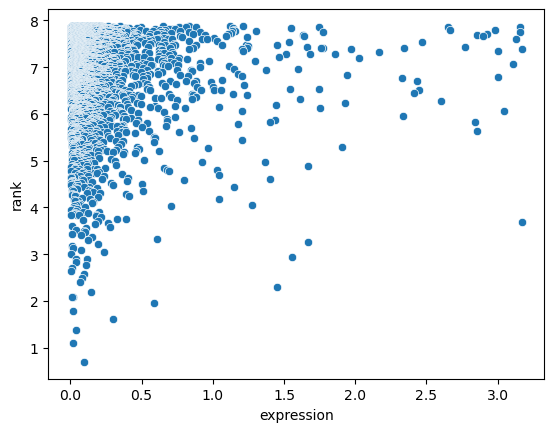

In [282]:
sns.scatterplot(svm_expression,x = "expression", y = "rank")

In [21]:
models = load_pickle_file(".+_with_MinMax_training_model_2024-01-22.+pkl")
svm_model = models["svm_with_MinMax_training_model_2024-01-22 16:11:41.pkl"]["model"]
svm_label = list(models["svm_with_MinMax_training_model_2024-01-22 16:11:41.pkl"]["original_label_classes"])

lg_model = models["logistic_with_MinMax_training_model_2024-01-22 16:15:58.pkl"]["model"]
lg_label = list(models["logistic_with_MinMax_training_model_2024-01-22 16:15:58.pkl"]["original_label_classes"])

In [27]:
data3 = data["matrix"].iloc[:, feature_index]
data3.columns = check_duplicated_elements(list(data3.columns))
svm_test_data = get_test_data(svm_model, data3, row_index=[20000, 200000], column_index=list(data2.columns))
lg_test_data = get_test_data(lg_model, data3, row_index=[20000, 200000], column_index=list(data2.columns))

In [28]:
svm_pred = svm_model.predict(svm_test_data[0])
lg_pred = lg_model.predict(lg_test_data[0])

svm_pred = [svm_label[i] for i in svm_pred]
lg_pred = [lg_label[i] for i in lg_pred]

In [29]:
accuracy_score(svm_pred, svm_test_data[1])

0.7231270358306189

In [30]:
accuracy_score(lg_pred, lg_test_data[1])

0.70646665315224

In [46]:
sum(x.pred == x.real)

1

In [56]:
x = pd.DataFrame([lg_pred, lg_test_data[1]]).T
x.columns = ["pred", "real"]
d = dict()
for i in set(x["pred"]):
    x_sub = x.loc[x.pred == i, :]
    x_sub["bool"] = x_sub.loc[:, "pred"] == x_sub.loc[:, "real"]
    d[i] = sum(x_sub["bool"])

/tmp/ipykernel_411814/128107205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_sub["bool"] = x_sub.loc[:, "pred"] == x_sub.loc[:, "real"]
/tmp/ipykernel_411814/128107205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_sub["bool"] = x_sub.loc[:, "pred"] == x_sub.loc[:, "real"]
/tmp/ipykernel_411814/128107205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [61]:
d["memory B cell"]

821

In [54]:
pd.DataFrame(lg_pred).value_counts()

memory B cell                                                                 902
naive B cell                                                                  624
effector memory CD8-positive, alpha-beta T cell                               570
classical monocyte                                                            480
central memory CD4-positive, alpha-beta T cell                                451
CD16-positive, CD56-dim natural killer cell, human                            362
CD16-negative, CD56-bright natural killer cell, human                         265
mucosal invariant T cell                                                      240
plasma cell                                                                   218
T follicular helper cell                                                      216
effector memory CD4-positive, alpha-beta T cell                               142
macrophage                                                                    108
cell            

In [55]:
pd.DataFrame(lg_test_data[1]).value_counts()

memory B cell                                                                 893
naive B cell                                                                  591
central memory CD4-positive, alpha-beta T cell                                473
effector memory CD8-positive, alpha-beta T cell                               379
classical monocyte                                                            346
CD16-positive, CD56-dim natural killer cell, human                            313
CD16-negative, CD56-bright natural killer cell, human                         309
plasma cell                                                                   195
effector memory CD4-positive, alpha-beta T cell                               166
T follicular helper cell                                                      156
mucosal invariant T cell                                                      136
neutrophil                                                                    134
gamma-delta T ce

In [52]:
features = load_pickle_file("svm_intersection_feature_selection_2024-01-17 21:53:44.pkl")
features = features["svm_intersection_feature_selection_2024-01-17 21:53:44.pkl"]["final_feature_selection_by_intersection"]

test2 = model_training(data = data2,
                       label_column = "cell_type",
                       normalization_method = "Min-Max",
                       features = features,
                       model = "svm",
                       filename="svm_with_MinMax",
                       logger = my_logger,
                       save = True,
                       cv = 5)

test3 = model_training(data = data2,
                       label_column = "cell_type",
                       normalization_method = "Min-Max",
                       features = features,
                       model = "logistic",
                       filename="logistic_with_MinMax",
                       logger = my_logger,
                       save = True,
                       cv = 5)

In [122]:
# models= ["logistic", "svm", "random_foreast"]
# d1 = {"lg_intersection": lg_int,
#      "lg_ensemble": lg_ensemble}
# d2 = {"RF_intersection": RF_int,
#      "RF_ensemble": RF_ensemble}
# d3 = {"svm_int": svm_int,
#      "svm_ensemble": svm_ensemble}
# d0 = {"logistic": d1,
#      "svm": d3,
#      "random_foreast":d2}

# for model in models:
# #     test = feature_selection(data = data2, 
# #                       label_column = "cell_type", 
# #                       filename = None,
# #                       variance_threshold = "zero",
# #                       model = i,
# #                       merge_rank_method = "geom.mean",
# #                       chi_square_test = False,
# #                       F_test = True,
# #                       mutual_info = False,
# #                       n_features_to_select = 3000,
# #                       logger = my_logger,
# #                       linear_svm_multi_class = "ovr",
# #                       normalization_method = "Min-Max",
# #                       save = True,
# #  
#     d0_copy = d0.copy()
#     d0_copy.pop(model)
#     for key in d0_copy:
#         for feature in d0_copy[key]:
#             filename = feature + "_" + model
#             test2 = model_training(data = data2,
#                           label_column = "cell_type",
#                           filename = filename,
#                           normalization_method = "Min-Max",
#                           features = d0_copy[key][feature],
#                           model = model,
#                           logger = my_logger,
#                           save = True,
#                           cv = 5)
            
# #     ensemble_features = [j[0] for j in test["final_feature_selection_by_ensemble"]]
# #     filename = i + "_ensemble"
# #     test2 = model_training(data = data2,
# #                   label_column = "cell_type",
# #                   filename = filename,
# #                   normalization_method = "Min-Max",
# #                   features = ensemble_features,
# #                   model = i,
# #                   logger = my_logger,
# #                   save = True,
# #                   cv = 5)

    

# # features = load_pickle_file(".+2024-01-16.+\.pkl")
# # ensemble_features = [ i[0] for i in features["svm_ensemble_feature_selection_2024-01-16 17:42:37.pkl"]["final_feature_selection_by_ensemble"]]
# # intersection_features = features["svm_intersection_feature_selection_2024-01-16 17:42:37.pkl"]["final_feature_selection_by_intersection"]

# # test2 = model_training(data = data2,
# #                   label_column = "cell_type",
# #                   filename = "svm_intersection",
# #                   normalization_method = "Min-Max",
# #                   features = intersection_features,
# #                   model = "svm",
# #                   logger = my_logger,
# #                   save = True,
# #                   cv = 5)

# # test3 = model_training(data = data2,
# #                   label_column = "cell_type",
# #                   filename = "svm_ensemble",
# #                   normalization_method = "Min-Max",
# #                   features = ensemble_features,
# #                   model = "svm",
# #                   logger = my_logger,
# #                   save = True,
# #                   cv = 5)
    


svm_int
logistic
2024-01-18 14:58:18 start model training
2024-01-18 14:58:18 model traning based on logistic algorithm
2024-01-18 14:58:18 grid search below paramters getting the best model
* penalty: ['l1', 'l2']
* C: [0.   0.25 0.5  0.75 1.  ]
* multi_class: ['ovr', 'multinomial']


/home/fengtang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fengtang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/fengtang/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 